# Review AIID clusters on per-point basis

create a spreadsheet listing each cluster to add annotations into

for each point's set of cluster
- remove clusters where <5 are Ovenbird songs of the same song variant
- merge clusters where the dominant song variant is the same
- mark cluster's in vs out clips 

then re-create a table of clips 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
def figsize(w,h):
    plt.rcParams['figure.figsize']=[w,h]
figsize(15,5) #for big visuals
%config InlineBackend.figure_format = 'retina'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

def identity(x):
    return x

from opensoundscape import Audio, Spectrogram

from IPython.display import clear_output

In [4]:
import ast


def parse_list_of_floats(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return None

In [ ]:
pam_dataset_path = "../../../pam_dataset_v4/"

cluster_samples = pd.read_csv(
    f"{pam_dataset_path}/per_point_clusters_sample10.csv",
    parse_dates=["datetime", "date"],
    converters={"features3d": parse_list_of_floats},
)

cluster_samples["year"] = cluster_samples["date"].apply(lambda x: x.year)
cluster_samples.drop_duplicates(subset="clip_name", inplace=True)

In [7]:
cluster_samples.cluster_30.nunique()

666

# review clusters
filter contaminated; merge; note outlier clips in retained clusters

- adding annotations to local spreadsheet on laptop

In [8]:
skip_until = "RK943"
skip = True

RK943 (2)


/home/sml161/miniconda3/envs/opso0120/lib/python3.11/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


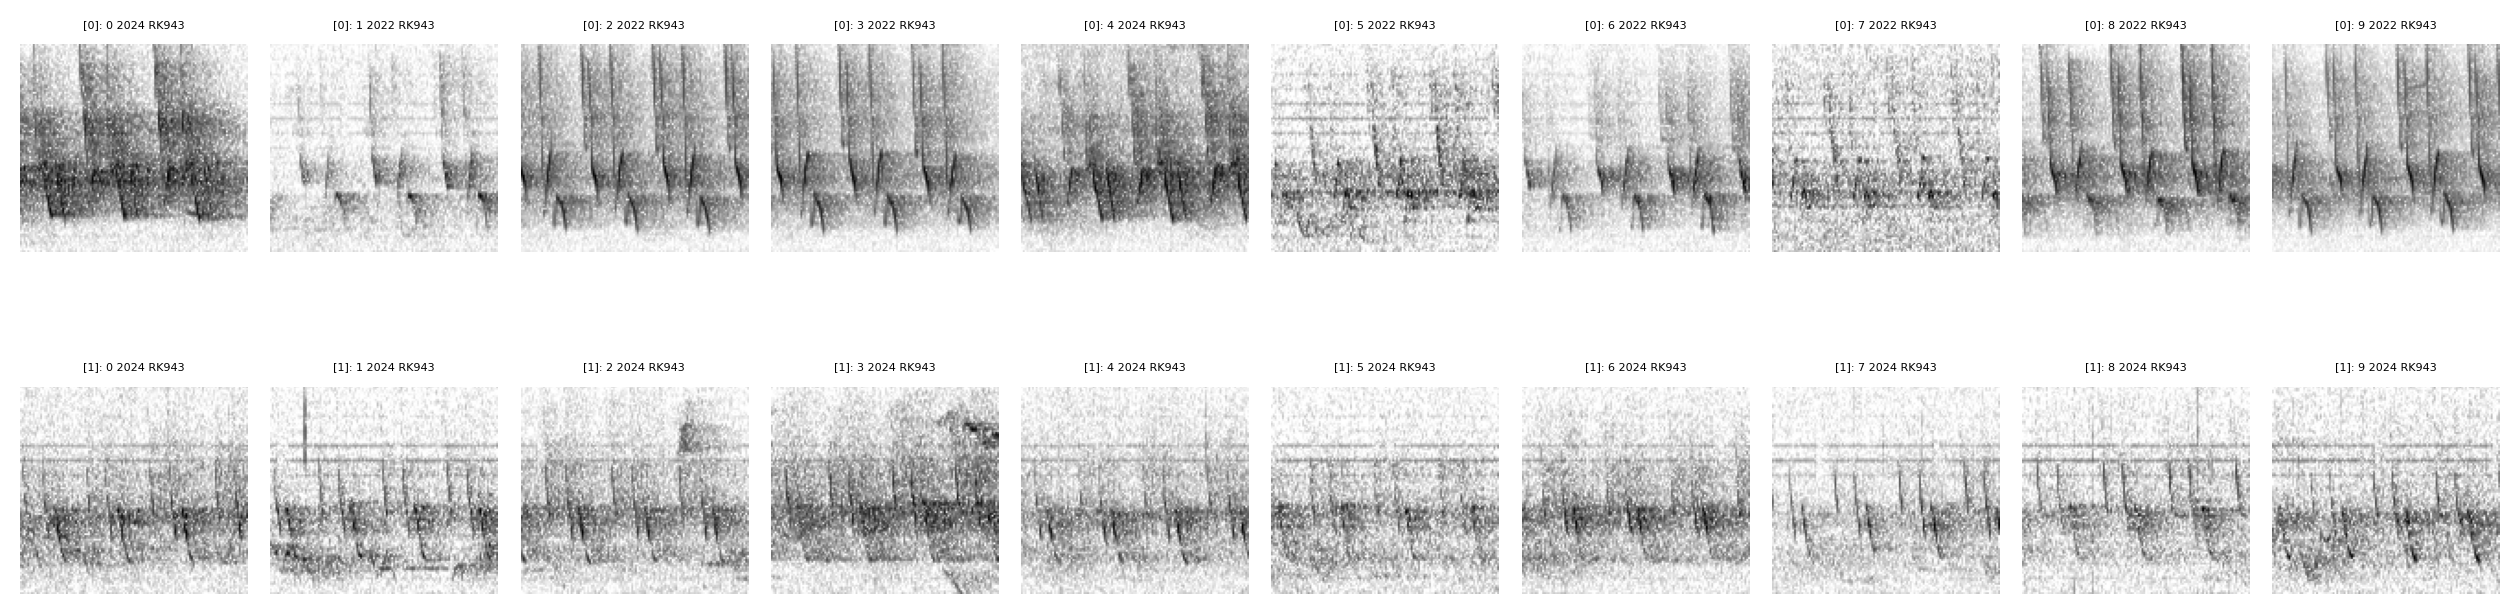

In [ ]:
n_per_cluster = 10
clip_dur = 1
spec_range = (-85, 0)

for point, point_dets in cluster_samples.groupby("point_code"):
    if point == skip_until:
        skip = False
    if skip:
        continue

    point_dets = point_dets[~point_dets.cluster_30.str.contains("-1")]

    # visualize samples from each cluster
    n_clusters = len(
        point_dets["cluster_30"].unique()
    )  # - 1 # skip the "-1" noise cluster

    if n_clusters < 1:
        continue
    print(f"{point} ({n_clusters})")

    fig, axes = plt.subplots(n_clusters, n_per_cluster, figsize=(16, 2 * n_clusters))
    if (
        len(axes.shape) == 1
    ):  # expand from 1 to expectd 2 dimensions when only 1 row present
        axes = np.array(axes[np.newaxis, :])
    current_row = 0

    for cluster_label, cluster in point_dets.groupby("cluster_30"):
        int_label = int(cluster_label.split("_")[1])
        if int_label < 0:  # do we want to inspect the "-1" unclustered class?
            continue

        for i, row in cluster.reset_index(drop=False).iterrows():
            ax = axes[current_row, i]
            a = Audio.from_file(
                row.file, offset=row.start_time + 1, duration=1, sample_rate=32000
            )
            ax.imshow(
                Spectrogram.from_audio(a)
                .bandpass(2000, 9000)
                .to_image(range=spec_range, return_type="np")[0],
                cmap="Greys",
            )
            ax.set_title(
                f"[{int_label}]: {i} {row.year} {row.point_code}",  # {'M' if row.cluster_100_medoid else ''}
                fontsize=4,
            )
        current_row += 1
        skip_until = row.point_code

        if current_row >= n_clusters:
            break

    # remove all axes
    for row in axes:
        for ax in row:
            ax.axis("off")  # Hide axes
            ax.set_xticks([])  # Remove x ticks
            ax.set_yticks([])  # Remove y ticks

    # Adjust spacing between images
    plt.subplots_adjust(wspace=0.1, hspace=0.25)

    plt.show()

    if input("x to exit") == "x":

        skip = True
        break
    clear_output()

# listen to audio clips for a cluster:
if visual inspection is insufficient, specify the cluster and get audio widgets with this cell

In [10]:
cluster_id = "RK890"
c = point_dets[point_dets["cluster_30"] == cluster_id]

for i, row in c.reset_index(drop=False).iterrows():
    print(i)
    a = Audio.from_file(row.file, offset=row.start_time + 1, duration=1)
    a = a._spawn(sample_rate=a.sample_rate / 6)
    a.show_widget(normalize=True)